In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import sys
from utils import *
import os
from simulator import Simulator
from Backtester import Backtester
from ARIMA_GARCH import ARIMA_GARCH
import os
print(os.getcwd()) 

# Go back up one directory
os.chdir("..")



# initialize the simulator
simulator = Simulator()



c:\Users\yinki\OneDrive\Python\Crypto Whales\src


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 990870672.4898235
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1.6256197074070966e+19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3249.2085211405633
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.913e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [2]:
results = simulator.simulate()

Test Period: 2023-05-25 to 2023-12-24
Lower Bound: 0.045691897967612645, Upper Bound: 0.07725618802258473
Amounts: 111.09977198036086 22.197455857889814
OK myliquidity 4712759625796295.0


c:\Users\yinki\OneDrive\Python\Crypto Whales\src\Backtester.py:109: RuntimeWarning: invalid value encountered in double_scalars
  dpd.iloc[i,dpd.columns.get_loc('ActiveLiq')] = (min(maxi,dpd['high'].iloc[i]) - max(dpd['low'].iloc[i],mini)) / (dpd['high'].iloc[i]-dpd['low'].iloc[i]) * 100


Amount Depositied WBTC: 14.87870763958442, Amount Deposited WETH: 218.65474852517372
Initial Amount in WBTC: 29.75741527916884
                  feeunb      feeV      feeusd    amountV  ActiveLiq  \
date                                                                   
2023-05-25  2.073460e-19  0.000495   21.161543  29.757415  65.000000   
2023-05-26  6.330416e-19  0.001516   64.822857  29.765732  88.888889   
2023-05-27  5.041904e-20  0.000118    5.061284  29.778062  68.181818   
2023-05-28  1.903810e-18  0.004562  195.073599  29.777244  90.909091   
2023-05-29  3.839729e-19  0.000749   32.022905  29.738376  77.272727   
...                  ...       ...         ...        ...        ...   
2023-12-19  2.058398e-18  0.004889  209.054324  26.075663  82.352941   
2023-12-20  9.215905e-18  0.022102  945.164643  25.862180  80.952381   
2023-12-21  3.564689e-18  0.008579  366.870912  25.396303  81.818182   
2023-12-22  5.437871e-18  0.012898  551.538334  25.670845  77.272727   
2023-12-2

c:\Users\yinki\OneDrive\Python\Crypto Whales\src\utils.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final3['amountVlast'].iloc[-1]=final3['HODL'].iloc[-1]


In [3]:
fee_results = results['Fee Results']
fee_results[0][-1]

{'Position Return': 2.37517702034093,
 'Base Return': 1.0275686937157892e-15,
 'Position APR': 4.070139025466852,
 'Base APR': 1.7608571512031128e-15,
 'Fees in Token 0': 0.3332982641683867,
 'Fees in Token 1': 6.577425672056832,
 'Total Fees in USD': 30224.42446616776,
 'Mean Percentage of Active Liquidity': 65.78865513531763}

In [4]:
fees = fee_results[0][0]
fees

,myfee0,myfee1,feeV,fgV,feeusd,ActiveLiq,amountV,amountunb,amountVlast,S1%,unb%,multiplier,feeunb
date,,,,,,,,,,,,,
2023-05-25,0.000349,0.002143,0.000495,1.053537e-19,21.161543,65.000000,29.757415,15.119919,29.765732,0.001663,6.967876e-19,2.386629e+15,2.073460e-19
2023-05-26,0.000903,0.008985,0.001516,3.217399e-19,64.822857,88.888889,29.765732,15.128270,29.777745,0.005093,2.126746e-18,2.394578e+15,6.330416e-19
2023-05-27,0.000056,0.000913,0.000118,2.563578e-20,5.061284,68.181818,29.778062,15.140785,29.777260,0.000397,1.693161e-19,2.347466e+15,5.041904e-20
2023-05-28,0.001704,0.042293,0.004562,9.679735e-19,195.073599,90.909091,29.777244,15.139950,29.731515,0.015320,6.393505e-18,2.396118e+15,1.903810e-18
2023-05-29,0.000748,0.000005,0.000749,1.949803e-19,32.022905,77.272727,29.738376,15.101059,29.767534,0.002518,1.291170e-18,1.950264e+15,3.839729e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19,0.001455,0.066284,0.004889,1.044661e-18,209.054324,82.352941,26.075663,13.233709,25.862180,0.018748,7.893942e-18,2.374997e+15,2.058398e-18
2023-12-20,0.009089,0.256780,0.022102,4.689919e-18,945.164643,80.952381,25.862180,13.161109,25.388216,0.085462,3.563468e-17,2.398295e+15,9.215905e-18
2023-12-21,0.005366,0.062866,0.008579,1.825915e-18,366.870912,81.818182,25.396303,13.008569,25.670845,0.033781,1.403625e-17,2.406716e+15,3.564689e-18


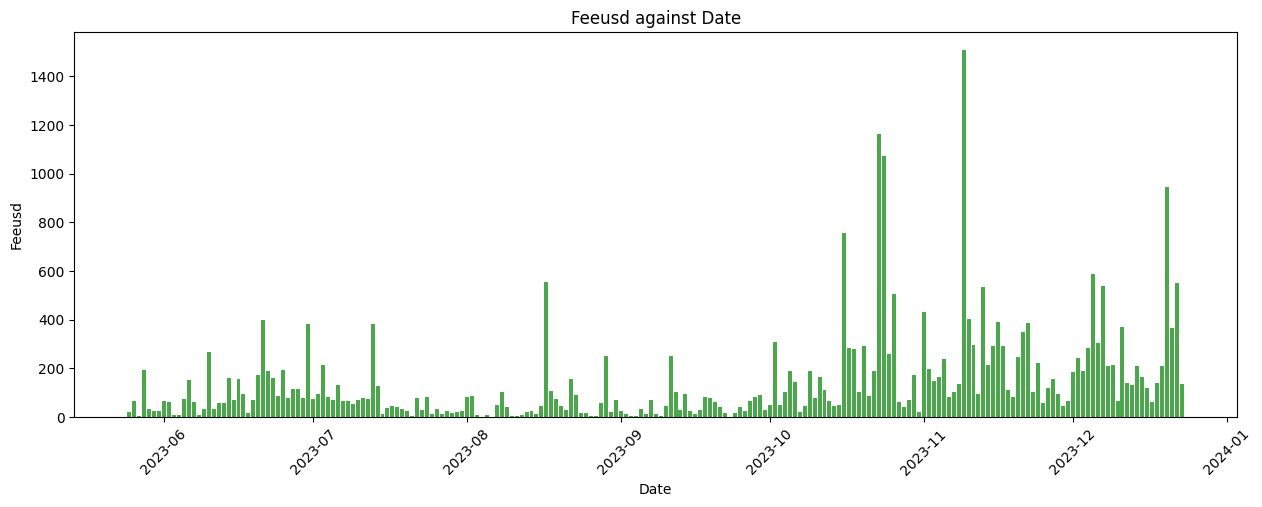

Text(0.5, 0, 'Date')

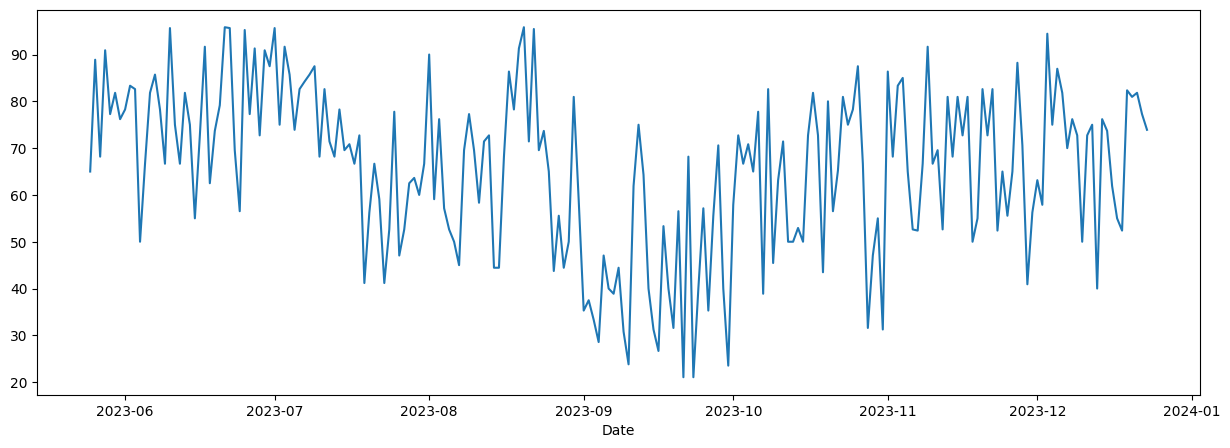

In [5]:
# Plot graph of feeusd against date, bargraph
plt.figure(figsize=(15, 5))
plt.bar(fees.index, fees['feeusd'], color='green', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Feeusd')
plt.title('Feeusd against Date')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


# Plot graph of activeliquidity per timeline
plt.figure(figsize=(15, 5))
plt.plot(fees['ActiveLiq'])
plt.xlabel('Date')



In [6]:
hodl = fee_results[0][1]
hodl

,amountV,amount0,amount1,close,feeV,amountVlast,HODL,IL,ActiveLiq,feecumsum,PNL,HODLnorm,ILnorm,PNLnorm,feecumsumnorm
date,,,,,,,,,,,,,,,
2023-05-25,29.757415,22.197456,111.099772,0.068047,0.000495,29.765732,437.309497,-407.543765,65.000000,0.000495,-407.543271,1469.581592,-1369.553644,-1369.551982,0.001663
2023-05-26,29.765732,22.265360,110.102421,0.068122,0.001516,29.777745,436.949431,-407.171685,88.888889,0.002011,-407.169675,1468.371586,-1368.303267,-1368.296510,0.006757
2023-05-27,29.778062,22.367115,108.609928,0.068235,0.000118,29.777260,436.410977,-406.633718,68.181818,0.002129,-406.631589,1466.562110,-1366.495423,-1366.488268,0.007155
2023-05-28,29.777244,22.360325,108.709438,0.068227,0.004562,29.731515,436.446864,-406.715349,90.909091,0.006691,-406.708658,1466.682708,-1366.769746,-1366.747261,0.022485
2023-05-29,29.738376,22.044113,113.356091,0.067877,0.000749,29.767534,438.124814,-408.357280,77.272727,0.007440,-408.349840,1472.321469,-1372.287466,-1372.262465,0.025001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19,26.075663,6.861216,368.601685,0.052128,0.004889,25.862180,536.926225,-511.064044,82.352941,0.659994,-510.404050,1804.344294,-1717.434258,-1715.216343,2.217916
2023-12-20,25.862180,6.270921,379.988123,0.051558,0.022102,25.388216,541.637155,-516.248939,80.952381,0.682097,-515.566842,1820.175408,-1734.858132,-1732.565941,2.292191
2023-12-21,25.396303,5.030660,404.326054,0.050369,0.008579,25.670845,551.793426,-526.122581,81.818182,0.690676,-525.431905,1854.305626,-1768.038574,-1765.717552,2.321021


In [7]:
next = fee_results[0][2]
next

,amountV,amountVlast,date,HODL,IL,feecumsum,PNL,HODLnorm,ILnorm,PNLnorm,feecumsumnorm
0,26.291405,26.205047,2023-12-23 23:00:00,498.673480,-472.468433,7.067913e-01,-471.761642,1896.716760,-1797.045225,-1794.356927,2.688298e+00
1,26.205047,26.212860,2023-12-23 22:00:00,499.322686,-473.109825,7.060783e-01,-472.403747,1899.186029,-1799.484775,-1796.799189,2.685586e+00
2,26.212860,26.212931,2023-12-23 21:00:00,499.264050,-473.051119,7.060044e-01,-472.345114,1898.963006,-1799.261482,-1796.576177,2.685305e+00
3,26.212931,26.221356,2023-12-23 20:00:00,499.263518,-473.042162,7.059317e-01,-472.336230,1898.960982,-1799.227415,-1796.542387,2.685029e+00
4,26.221356,26.221252,2023-12-23 19:00:00,499.200275,-472.979023,7.059317e-01,-472.273091,1898.720436,-1798.987263,-1796.302234,2.685029e+00
...,...,...,...,...,...,...,...,...,...,...,...
4340,29.754069,29.754078,2023-05-25 06:00:00,466.800952,-437.046874,8.260133e-05,-437.046791,1775.488820,-1662.318457,-1662.318143,3.141762e-04
4341,29.754078,29.754048,2023-05-25 05:00:00,466.800827,-437.046780,8.260133e-05,-437.046697,1775.488346,-1662.318100,-1662.317786,3.141762e-04
4342,29.754048,29.757416,2023-05-25 04:00:00,466.801268,-437.043852,8.260133e-05,-437.043769,1775.490021,-1662.306964,-1662.306650,3.141762e-04
4343,29.757416,29.757415,2023-05-25 03:00:00,466.752404,-436.994989,2.912761e-08,-436.994988,1775.304166,-1662.121111,-1662.121110,1.107876e-07
